В этом практическом задании мы рассмотрим задачу восстановления синтаксических зависимостей между словами в предложении на примере предсказания результата вычисления математического выражения. Пример данных, с которыми нам предстоит работать можно видеть ниже.

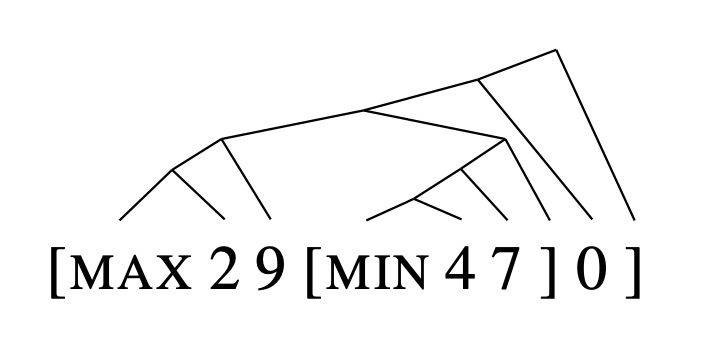

Над математическим выражением можно видеть дерево синтаксического разбора. В популярных доступных корпусах текстов такая аннотация доступна только для небольшого подмножества текстов, а ручная аннотация может занимать большое количество времени. Поэтому мы заинтересованы в создании моделей машинного обучения, которые могли бы автоматически восстанавливать такого рода зависимости из данных в режиме "без учителя". В данном задании мы будем реализовывать и обучать модель со скрытыми переменными, в которой в качестве скрытых переменных будет выступать такой граф. Данный подход позволит решить проблему отсутствия аннотаций и помимо решения задачи вычисления результата математического выражения, еще и позволит автоматически восстанавливать деревья зависимостей из данных.

Перейдем к делу, ниже идут ячейки, которые загружают нужные нам модули и импортируют библиотеки.

In [1]:
!git clone https://github.com/agadetsky/sochischool.git

Cloning into 'sochischool'...
remote: Enumerating objects: 302, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 302 (delta 29), reused 19 (delta 8), pack-reused 231
Receiving objects: 100% (302/302), 51.05 MiB | 32.75 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Checking out files: 100% (195/195), done.


In [2]:
!pip install -qU git+https://github.com/harvardnlp/pytorch-struct

In [3]:
import random
import sys
sys.path.append('/content/sochischool/')

In [4]:
import torch
import torch.nn as nn
import numpy as np
from torch_struct import DependencyCRF
from tqdm import tqdm

In [5]:
import listops.data as _data
import listops.model_modules.archer as _archer
import listops.model_modules.sampler as _sampler
import listops.model_modules.computer as _computer
import listops.model_modules.decoder as _decoder
import listops.data_processing.python.loading as _loading
from listops.school_utils import compute_metrics
from listops.model_modules.sampler import DependencySampler, BinaryIndependentSampler

In [6]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [7]:
%%capture

datasets = _data.get_datasets(
    "var_5_50_nosm_20000",
    datadirpath="/content/sochischool/listops/data_processing/python/listops/data"
  )

In [8]:
%%capture

train_loader, val_loader, test_loader  = _data.get_dataloaders(datasets, batchsize=50)

Вся работа с данными была реализована за вас. Так как мы работаем с синтетическими данными, то нам известны правильные деревья разбора, которые мы в будущем будем использовать для оценивания качества их восстановления.

$$
\begin{align*}
x & \in \{0, \dots \lvert V \rvert - 1\}^{n} \text{ - последовательность длины } n,\ V \text{ - словарь используемых символов} \\
y & \in \{0, \dots, 9\} \text{ - метки класса (результат выражения - число от 0 до 9)}\\
\text{arcs} & \in \{0, 1\}^{n \times n} \text{ - граф зависимостей между словами в } x\ (\text{arcs}_{ij} = 1 \implies x_i \rightarrow x_j)
\end{align*}
$$

In [9]:
x, y, arcs, lengths, depths = next(iter(train_loader))

In [10]:
def print_eq(x, y):
  print(" ".join([_loading.ix_to_word[elem] for elem in x if elem != _loading.word_to_ix["<PAD>"]]) + " = " + str(y.item()))

In [11]:
idx = 33
print_eq(x[idx].cpu().numpy().tolist(), y[idx])

[MIN 8 8 9 [MED 1 6 0 ] ] = 1


Теперь перейдем к модели, ниже можно видеть диаграмму модели, которую мы будем использовать.

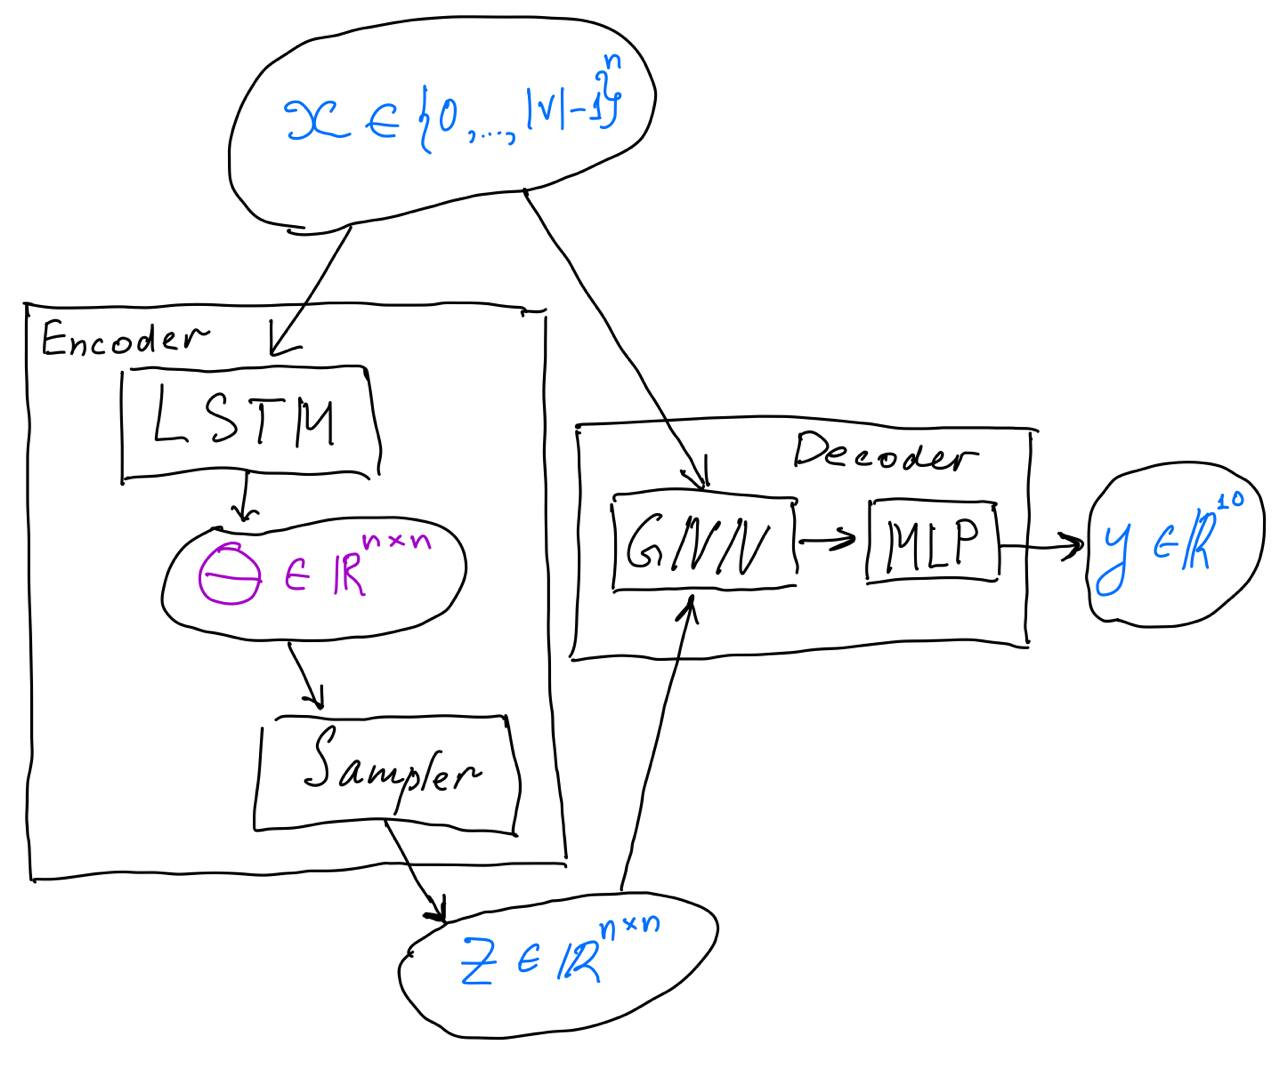

Модель представляет собой архитектуру вида encoder-decoder. Encoder по входу $x$ выдает параметры распределения $\theta$ над графами. Модуль `Sampler` выдает сэмпл из соответствующего распределения над графами. А decoder - классификатор (графовая нейронная сеть), который по графу и последовательности $x$ выдает предсказания класса. А именно, каждое слово $x_i$ считается вершиной в графе. Для каждого такого слова $x_i$ в последовательности заводится обучаемое векторное представление $v_i$. Затем для каждого ребра $(i, j)$ в поданном графе передается "сообщение" $f((v_i, v_j))$. В конце концов все сообщения агрегируются и обновляются текущие векторные представления для слов $v_i$. И так повторяется $T$ раз, в итоге мы получаем на выходе обновленные векторные представления для вершин графа $v_i^T$. В нашей модели, мы пропускаем $v_0^T$ через линейный слой и получаем ненормированные вероятности для классов.

In [12]:
class ModelBase(nn.Module):

    def __init__(self, sampler_str, comp_str, dec_str, tau):
        super().__init__()
        if isinstance(sampler_str, str):
            self.sampler  = _sampler.get_sampler(sampler_str, tau)
        else:
            self.sampler = sampler_str
        self.computer = _computer.get_computer(comp_str)
        self.decoder  = _decoder.get_decoder(dec_str)
        self.tau = tau


class Model(nn.Module):

    def __init__(self, archer_str, sampler_str, comp_str, dec_str, tau):
        super().__init__()
        self.base = ModelBase(sampler_str, comp_str, dec_str, tau)
        self.archer  = _archer.get_archer(archer_str)
        self.sample = None

    def save_weights(self, path):
        torch.save(self.state_dict(), path)

    def load_weights(self, weights):
        self.load_state_dict(weights)

    def forward(self, x, arcs, lengths, training_mode=None):
        arc_logits = self.archer(x, arcs, lengths) # true arcs used only for groundtruth sampler
        sample = self.base.sampler(arc_logits, lengths, training_mode=training_mode) # sampler never depends on tokens
        comp = self.base.computer(x, sample, lengths) # computer only depends on sample, not on arcs
        pred = self.base.decoder(comp)
        # Save for easy access in .eval() to inspect sample
        self.sample = sample.detach()
        return pred


def get_school_model(sampler):
    m = Model(
        archer_str="lstm_1_60_60_0.1",
        sampler_str=sampler,
        comp_str="kipf_mlp_5_60_60_0.1",
        dec_str="mlp_1_60_60",
        tau=1.0 # dummy, not really used, tau is defined in Sampler
    )
    return m

Большая часть модели реализована за вас, вам нужно реализовать только модуль `Sampler`, который реализует сэмплирование скрытых переменных по вектору параметров распределения.

На первом семинаре мы не будем учитывать знание о том, что граф синтаксических зависимостей имеет определенную структуру, и для простоты будем моделировать распределение над ребрами как независимые бинарные случайные величины, а именно:

$$p(z|x, \theta) = \prod_{i=1}^{n}\prod_{j=1}^{n}p(z_{ij} | x, \theta_{ij}) = \prod_{i=1}^{n}\prod_{j=1}^{n} \text{Bin}(z_{ij}|\theta_{ij}(x))$$

где $\theta$ - нейронная сеть (encoder), выдающая параметры распределения.

Для того, чтобы граф вычислений модели был дифференцируемым воспользуемся Gumbel-Softmax трюком для нашего распределения, а именно:

$$
\begin{align*}
u_{ij} & \sim \text{Uniform}(0, 1) \\
l_{ij} & = \text{log}(u_{ij}) - \text{log}(1 - u_{ij}) \\
\hat{\theta}_{ij} & = (l_{ij} + \theta_{ij}) / \tau \\
\hat{z}_{ij} & = \sigma(\hat{\theta}_{ij})
\end{align*}
$$

Известно, что при устремлении температуры $\tau$ к нулю, релаксация переходит в бинарное дискретное распределение, но градиенты по $\theta$ соответственно становятся неинформативными, поэтому использование слишком низких температур нежелательно. На практике чаще всего используют $\tau=1.0$, но можно поиграться с этим гиперпараметром.


Ниже вам нужно реализовать сэмплер, для описанных выше распределений.
Метод `inject_noise` по параметрам распределения $\theta$ выдает зашумленную версию $\hat{\theta}$. Метод `sample` использует `inject_noise` для сэмплирования либо релаксации (`mode=soft`), либо бинарного дискретного сэмпла (`mode=hard`).

In [13]:
class BinarySampler(BinaryIndependentSampler):

    def __init__(self, noise, tau):
        assert noise in set(['logistic'])
        super(BinarySampler, self).__init__("soft", noise, tau)

    def inject_noise(self, theta):
        if self.noise == "logistic":
            u = torch.distributions.utils.clamp_probs(torch.rand_like(theta))
            noise = u.log() - u.neg().log1p()
            return (theta + noise) / self.tau

    def sample(self, theta, lengths, mode):
        if mode == "soft":
            return self.inject_noise(theta).sigmoid()
        elif mode == "hard":
            return (self.inject_noise(theta.detach()) > 0.0).float()

Мы на финишной прямой, осталось реализовать функцию `training` для обучения модели. У нас задача классификации, соответственно оптимизируемый функционал выглядит следующим образом:

$$\mathbb{E}_{(x, y)} \mathbb{E}_{\hat{z}} \text{CrossEntropy}(\hat{y}_{\phi}(x, \hat{z}), y) \rightarrow \min\limits_{\theta, \phi}$$

где $\hat{y}_{\phi}(x, \hat{z})$ - нейронная сеть (decoder), выдающая предсказания модели.

Для удобства ниже опишем сигнатуру функции `training` и модели `m`

`m` - это `torch.nn.Module`, поэтому имеем следующее:

`m(x, arcs, lengths)` выдает предсказания $\hat{y}_{\phi}(x, \hat{z})$

`m.sample` - это сэмпл $\hat{z}$ для последнего прогнанного $x$

В режиме `m.train()`, `m.sample` - это релаксация (`mode=soft` в `Sampler`), а в режиме `m.eval()`, `m.sample` - это дискретное распределение (`mode=hard` в `Sampler`).
 

In [14]:
def training(m, train_loader, opt, num_epochs):
    m.train()
    for _ in range(num_epochs):
        for batch_idx, (x, y, arcs, lengths, depths) in enumerate(tqdm(train_loader)):
            opt.zero_grad()

            x = x.cuda()
            y = y.cuda()
            arcs = arcs.cuda()
            lengths = lengths.cuda()
            
            with torch.set_grad_enabled(True):
                pred_logits = m(x, arcs, lengths)
                loss = torch.nn.functional.cross_entropy(pred_logits, y)
                loss.backward()
                opt.step()

Также реализуем функцию `validation` для валидации модели на отложенной выборке. Тут все аналогично функции `training`. Дополнительно, помимо функции потерь, посчитайте метрики: качество предсказаний модели, а также метрики качества восстановления графа связей - precision и recall. Для подсчета precision и recall воспользуйтесь функцией `compute_metrics(m.sample, arcs, lengths)`, которая была импортирована в начале ноутбука.

In [15]:
def validation(m, val_loader):
    m.eval()
    val_losses = []
    val_accs = []
    val_precs = []
    val_recs = []
    for batch_idx, (x, y, arcs, lengths, depths) in enumerate(tqdm(val_loader)):
        x = x.cuda()
        y = y.cuda()
        arcs = arcs.cuda()
        lengths = lengths.cuda()
        with torch.no_grad():
          pred_logits = m(x, arcs, lengths)
          loss = torch.nn.functional.cross_entropy(pred_logits, y)
          acc = (pred_logits.argmax(-1) == y).float().mean()
          precision, recall = (compute_metrics(m.sample, arcs, lengths))

        val_losses.append(loss.item())
        val_accs.append(acc.item())
        val_precs.append(precision.item())
        val_recs.append(recall.item())
    return val_losses, val_accs, val_precs, val_recs

Пришло время обучить модель.

In [16]:
sampler = BinarySampler("logistic", 1.0)
m = get_school_model(sampler)
m.cuda()
opt = torch.optim.AdamW(m.parameters())
training(m, train_loader, opt, num_epochs=2)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
 12%|█▏        | 231/2000 [00:21<02:41, 10.95it/s]


KeyboardInterrupt: ignored

In [ ]:
val_losses, val_accs, val_precs, val_recs = validation(m, val_loader)

100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


In [ ]:
np.mean(val_losses)

0.530943063646555

In [ ]:
np.mean(val_accs)

0.8084000408649444

In [ ]:
np.mean(val_precs)

0.10717825219035149

In [ ]:
np.mean(val_recs)

0.40346491038799287

Как мы видим, качество восстановления деревьев синтаксических зависимостей оставляет желать лучшего. Можно сказать, что это было ожидаемо, - мы никак не учли знание о том, что в нашей задаче эти деревья являются направленными остовами (rooted arborescence). Дальше мы исправим это и воспользуемся структурным распределением для моделирования таких деревьев, взамен независимым распределениям как раньше.

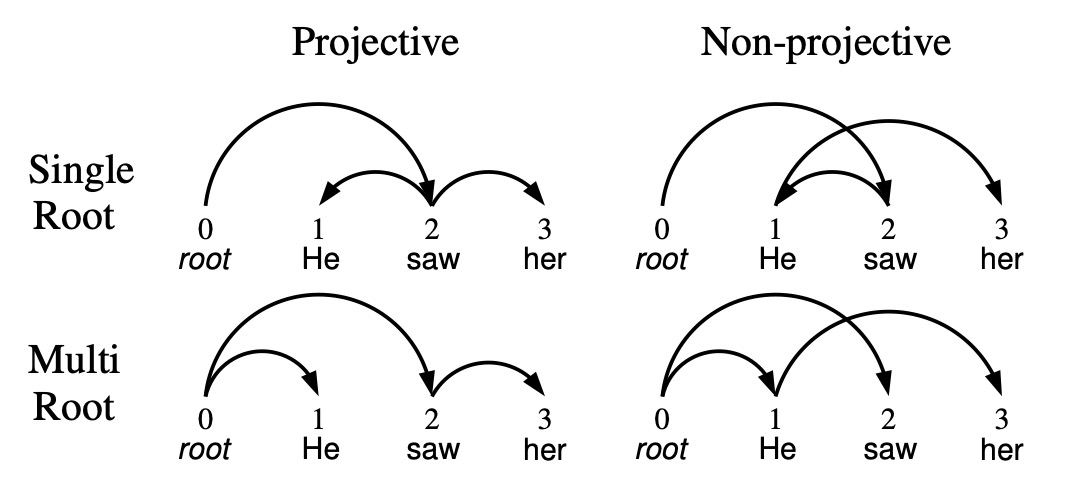

В лингвиcтических приложениях такие деревья различают по двум характеристикам: single/multi root - от корня может исходить одно/множество ребер и projective/non-projective - ребра не могут пересекаться (при отображении графа на плоскость) либо могут. Мы будем использовать multi root projective деревья. С лингвистической точки зрения, зависимости между словами, которые описываются projective деревьями, соответствуют наложению дополнительных ограничений на порядок слов в предложении. Таким образом, некоторые зависимости между словами могут не описываться projective деревьями, но в рамках нашего задания это не так важно, и для простоты реализации, мы будем пользоваться именно такой структурой.

Для того, чтобы моделировать наши скрытые переменные, нам нужно определить структурное распределение и релаксацию с помощью Stochastic Softmax Trick.
Как было обсуждено на лекции, большое количество релаксаций может быть получено с помощью вычисления маргиналов для соответствующей графической модели $p(z|x, \theta)$ из экспоненциального семейства распределений. А именно, рассмотрим распределение над нашими projective деревьями $z \in \mathcal{Z}$ как распределение из экспоненциального семейства с параметрами $\theta(x)$:

$$p(z|x, \theta) \propto \text{exp}(z^T \theta(x) / \tau)$$

Подсчет логарифма нормировочной константы для такого распределения вычислительно неэффективен, так как сумма $A(\theta) = \text{log} \sum_{z \in \mathcal{Z}} \text{exp}(z^T \theta(x) / \tau)$ содержит экспоненциально большое количество членов. Но оказывается, что для того, чтобы определить Stochastic Argmax Trick (SMT) и Stochastic Softmax Trick (SST) для такой модели, нам и не нужно уметь считать нормировочную константу. SMT по определению это:

$$\arg \max_{z \in \mathcal{Z}} p(z|x, \theta) = \arg \max_{z \in \mathcal{Z}} z^T \theta(x)$$


А SST мы можем определить с помощью маргиналов $\mu(\theta) = \mathbb{E}_{z} p(z|x, \theta)$ для этой модели. А именно можно показать, что существует такая сильно-выпуклая функция $A^*$, что

$$\mu(\theta) = \mathbb{E}_z p(z|x, \theta) = \arg \max_{z \in \text{Conv}(\mathcal{Z})} z^T \theta(x) + \tau A^*(z)$$

что в свою очередь и является определением Stochastic Softmax Trick.

Вычисление маргиналов $\mu(\theta)$ в графической модели как и вычисление $\arg \max_{z} p(z|x, \theta)$ в общем случае является очень сложной вычислительной задачей. Но оказывается, что в нашем случае существуют эффективные алгоритмы, которыми мы и воспользуемся.

Соответственно релаксацию будем определять следующим образом:

$$
\begin{align*}
u_{ij} & \sim \text{Uniform}(0, 1) \\
g_{ij} & = -\text{log}(-\text{log}(u_{ij})) \\
\hat{\theta}_{ij} & = (g_{ij} + \theta_{ij}) / \tau \\
\hat{z}_{ij} & = \mu(\hat{\theta}_{ij})
\end{align*}
$$

где $\hat{z}_{ij}$ - будет нашей релаксацией, посчитанной с помощью вычисления маргиналов в соответствующей графической модели. А дискретный сэмпл будем получать вычислением $\arg\max_{z} p(z|x, \hat{\theta})$.

Эта релаксация с использованием шума из распределения Гумбеля, но можно также попробовать поиграться с различными видами шума, например с гауссовским (принципиально ничего не меняется):

$$
\begin{align*}
n_{ij} & \sim \text{Normal}(0, 1) \\
\hat{\theta}_{ij} & = (n_{ij} + \theta_{ij}) / \tau \\
\hat{z}_{ij} & = \mu(\hat{\theta}_{ij})
\end{align*}
$$

С точки зрения реализации от предыдущего класса отличий никаких нет. Вам необходимо реализовать метод `inject_noise` и `sample`. Для реализации `sample` (вычисление маргиналов и аргмаксимума) воспользуйтесь классом `DependencyCRF` из `pytorch-struct` [ссылка на документацию](http://nlp.seas.harvard.edu/pytorch-struct/model.html#Dependency-Tree) (он уже импортирован в начале ноутбука).

In [ ]:
class ProjectiveSampler(DependencySampler):

    def __init__(self, noise, tau):
        assert noise in set(['gumbel', 'gaussian'])
        super(ProjectiveSampler, self).__init__("soft", noise, tau, True, False)
        
    def inject_noise(self, theta):
        if self.noise == "gumbel":
            u = torch.distributions.utils.clamp_probs(torch.rand_like(theta))
            noise = u.log().neg().log().neg()
            return (theta + noise) / self.tau
        elif self.noise == "gaussian":
            noise = torch.randn_like(theta)
            return (theta + noise) / self.tau

    def sample(self, theta, lengths, mode):
        if mode == "soft":
            return DependencyCRF(self.inject_noise(theta), lengths).marginals
        elif mode == "hard":
            return DependencyCRF(self.inject_noise(theta), lengths).argmax.detach()

In [ ]:
sampler = ProjectiveSampler("gumbel", 1.0)
m = get_school_model(sampler)
m.cuda()
opt = torch.optim.AdamW(m.parameters())
training(m, train_loader, opt, num_epochs=2)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
100%|██████████| 2000/2000 [12:03<00:00,  2.77it/s]


In [ ]:
val_losses, val_accs, val_precs, val_recs = validation(m, val_loader)

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


In [ ]:
np.mean(val_losses)

0.7142713025212288

In [ ]:
np.mean(val_accs)

0.7508000373840332

In [ ]:
np.mean(val_precs)

0.6151826977729797

In [ ]:
np.mean(val_recs)

0.6151826977729797

REFERENCES


1.   Max. B. Paulus, Dami Choi, Daniel Tarlow, Andreas Krause, Chris J. Maddison. Gradient Estimation with Stochastic Softmax Tricks. NeurIPS 2020.
2.   Nikita Nangia, Samuel Bowman. ListOps: A Diagnostic Dataset for Latent Tree Learning. NAACL 2018.
3.   Caio Corro, Ivan Titov. Differentiable Perturb-and-Parse: Semi-Supervised Parsing with a Structured Variational Autoencoder. ICLR 2019.
4.   Terry Koo, Amir Globerson, Xavier Carreras, Michael Collins. Structured Prediction Models via the Matrix-Tree Theorem. EMNLP 2007.

